# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [1]:
% matplotlib inline
import datetime
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

## Load the data into a DataFrame
# pd.read_csv()
iowa = pd.read_csv('/Users/Tamara/Desktop/Project 3/Iowa_Liquor_sales_sample_10pct.csv')
iowa.head()
## Transform the dates if needed, e.g.
# df["Date"] = pd.to_datetime(df["Date"], format="%m-%d-%y")

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,03/02/2016,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,02/11/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34
3,02/03/2016,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.5,2.77
4,08/18/2015,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.0,5.55


In [2]:
iowa["Date"] = pd.to_datetime(iowa["Date"])

In [3]:
iowa['State Bottle Cost'] = [dollars.strip('$') for dollars in iowa['State Bottle Cost']]
iowa['State Bottle Retail'] = [dollars.strip('$') for dollars in iowa['State Bottle Retail']]
iowa['Sale (Dollars)'] = [dollars.strip('$') for dollars in iowa['Sale (Dollars)']]

In [4]:
# Converting to numeric value
# If ‘coerce’, then invalid parsing will be set as NaN

iowa['Zip Code'] = pd.to_numeric(iowa['Zip Code'], errors='coerce')
iowa['County Number'] = pd.to_numeric(iowa['County Number'], errors='coerce')
iowa['Store Number'] = pd.to_numeric(iowa['Store Number'], errors='coerce')
iowa['State Bottle Cost'] = pd.to_numeric(iowa['State Bottle Cost'], errors='coerce')
iowa['State Bottle Retail'] = pd.to_numeric(iowa['State Bottle Retail'], errors='coerce')
iowa['Sale (Dollars)'] = pd.to_numeric(iowa['Sale (Dollars)'], errors='coerce')

In [5]:
iowa.dtypes

Date                     datetime64[ns]
Store Number                      int64
City                             object
Zip Code                        float64
County Number                   float64
County                           object
Category                        float64
Category Name                    object
Vendor Number                     int64
Item Number                       int64
Item Description                 object
Bottle Volume (ml)                int64
State Bottle Cost               float64
State Bottle Retail             float64
Bottles Sold                      int64
Sale (Dollars)                  float64
Volume Sold (Liters)            float64
Volume Sold (Gallons)           float64
dtype: object

In [6]:
iowa.sort_values(["Bottle Volume (ml)"], inplace=True)

In [7]:
iowa['Price per Liter'] = iowa['State Bottle Retail']/(iowa['Bottle Volume (ml)']/1000)
iowa['Margin'] = iowa['State Bottle Retail'] - iowa['State Bottle Cost']

In [8]:
iowa.sort_values(["Store Number", "Date"], inplace=True)
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20151231")
mask = (iowa['Date'] >= start_date) & (iowa['Date'] <= end_date)
iowa_sales_2015 = iowa[mask]

In [9]:
# Group by store number
iowa_sales_2015 = iowa_sales_2015.groupby(["Store Number"], as_index=False)

In [10]:
# Calculating the sum and the mean
iowa_sales_2015 = iowa_sales_2015.agg({"Sale (Dollars)": [np.sum, np.mean],
                   "Volume Sold (Liters)": [np.sum, np.mean],
                   "Margin": [np.sum, np.mean],
                   "Price per Liter": [np.sum, np.mean],
                   "Zip Code": lambda x: x.iloc[0], 
                   "City": lambda x: x.iloc[0],
                   "County Number": lambda x: x.iloc[0]})

In [11]:
# Collapsing the column indices
iowa_sales_2015.columns = iowa_sales_2015.columns.get_level_values(0)

In [12]:
# Renaming the columns
iowa_sales_2015.columns = ['store_number','city','2015_sales_sum','2015_sales_mean','county','2015_price_per_liter_sum','2015_price_per_liter_mean'
                     ,'zip_code','2015_volume_sold_liters_sum','2015_volume_sold_liters_mean','2015_margin_sum','2015_margin_mean']

In [13]:
iowa_sales_2015.head()

,store_number,city,2015_sales_sum,2015_sales_mean,county,2015_price_per_liter_sum,2015_price_per_liter_mean,zip_code,2015_volume_sold_liters_sum,2015_volume_sold_liters_mean,2015_margin_sum,2015_margin_mean
0,2106,CEDAR FALLS,146326.22,277.658861,7.0,9410.428571,17.856601,50613.0,9731.85,18.466509,2722.65,5.166319
1,2113,GOWRIE,9310.22,63.334830,94.0,2720.130952,18.504292,50543.0,659.85,4.488776,800.43,5.445102
2,2130,WATERLOO,111871.43,285.386301,7.0,6599.582381,16.835669,50703.0,6891.37,17.580026,1930.93,4.925842
3,2152,ROCKWELL,7721.08,54.759433,17.0,1835.958571,13.020983,50469.0,633.37,4.491986,609.49,4.322624
4,2178,WAUKON,24324.18,102.633671,3.0,3806.726190,16.062136,52172.0,1917.12,8.089114,1153.92,4.868861


In [14]:
# total sales of all stores for all of 2015
iowa_sales_2015['2015_sales_sum'].sum()

28527245.390000015

In [15]:
# Average total sales of all stores for all of 2015
iowa_sales_2015['2015_sales_sum'].mean()

20792.452908163275

In [16]:
# Finding Q1 2015 by store number 

iowa.sort_values(["Store Number", "Date"], inplace=True)
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20150331")
mask = (iowa['Date'] >= start_date) & (iowa['Date'] <= end_date)
iowa_sales_Q1_2015 = iowa[mask]

In [17]:
#Grouping by Store number
iowa_sales_Q1_2015 = iowa_sales_Q1_2015.groupby(by=["Store Number"], as_index=False)

In [18]:
# Calculating the sums and means
iowa_sales_Q1_2015 = iowa_sales_Q1_2015.agg({"Sale (Dollars)": [np.sum, np.mean],
                   "Volume Sold (Liters)": [np.sum, np.mean],
                   "Margin": [np.sum, np.mean],
                   "Price per Liter": [np.sum, np.mean],
                   "Zip Code": lambda x: x.iloc[0], 
                   "City": lambda x: x.iloc[0],
                   "County Number": lambda x: x.iloc[0]})

In [19]:
# Collapsing the columns indeces
iowa_sales_Q1_2015.columns = iowa_sales_Q1_2015.columns.get_level_values(0)

In [20]:
# Renaming the columns
iowa_sales_Q1_2015.columns = ['store_number','city','2015_q1_sales_sum','2015_q1_sales_mean','county','2015_q1_price_per_liter_sum','2015_q1_price_per_liter_mean'
                     ,'zip_code','2015_q1_volume_sold_liters_sum','2015_q1_volume_sold_liters_mean','2015_q1_margin_sum','2015_q1_margin_mean']

In [21]:
iowa_sales_Q1_2015.head()

,store_number,city,2015_q1_sales_sum,2015_q1_sales_mean,county,2015_q1_price_per_liter_sum,2015_q1_price_per_liter_mean,zip_code,2015_q1_volume_sold_liters_sum,2015_q1_volume_sold_liters_mean,2015_q1_margin_sum,2015_q1_margin_mean
0,2106,CEDAR FALLS,39287.29,304.552636,7.0,2302.212381,17.846608,50613.0,2526.10,19.582171,649.35,5.033721
1,2113,GOWRIE,2833.25,67.458333,94.0,813.041905,19.358141,50543.0,177.11,4.216905,221.55,5.275000
2,2130,WATERLOO,24272.57,278.995057,7.0,1528.192381,17.565430,50703.0,1447.25,16.635057,447.26,5.140920
3,2152,ROCKWELL,2003.46,62.608125,17.0,447.712381,13.991012,50469.0,151.74,4.741875,154.78,4.836875
4,2178,WAUKON,5856.41,122.008542,3.0,802.786190,16.724712,52172.0,409.81,8.537708,236.74,4.932083


In [22]:
iowa_sales_Q1_2015['2015_q1_sales_sum'].sum()

6153795.89

In [23]:
#Merging Q1 2015 sales and 2015 sales together using pd.merge into one dataframe
merge_2015 = pd.merge(iowa_sales_Q1_2015, iowa_sales_2015, on=['store_number','city','county'])

In [24]:
merge_2015.head()

,store_number,city,2015_q1_sales_sum,2015_q1_sales_mean,county,2015_q1_price_per_liter_sum,2015_q1_price_per_liter_mean,zip_code_x,2015_q1_volume_sold_liters_sum,2015_q1_volume_sold_liters_mean,...,2015_q1_margin_mean,2015_sales_sum,2015_sales_mean,2015_price_per_liter_sum,2015_price_per_liter_mean,zip_code_y,2015_volume_sold_liters_sum,2015_volume_sold_liters_mean,2015_margin_sum,2015_margin_mean
0,2106,CEDAR FALLS,39287.29,304.552636,7.0,2302.212381,17.846608,50613.0,2526.10,19.582171,...,5.033721,146326.22,277.658861,9410.428571,17.856601,50613.0,9731.85,18.466509,2722.65,5.166319
1,2113,GOWRIE,2833.25,67.458333,94.0,813.041905,19.358141,50543.0,177.11,4.216905,...,5.275000,9310.22,63.334830,2720.130952,18.504292,50543.0,659.85,4.488776,800.43,5.445102
2,2130,WATERLOO,24272.57,278.995057,7.0,1528.192381,17.565430,50703.0,1447.25,16.635057,...,5.140920,111871.43,285.386301,6599.582381,16.835669,50703.0,6891.37,17.580026,1930.93,4.925842
3,2152,ROCKWELL,2003.46,62.608125,17.0,447.712381,13.991012,50469.0,151.74,4.741875,...,4.836875,7721.08,54.759433,1835.958571,13.020983,50469.0,633.37,4.491986,609.49,4.322624
4,2178,WAUKON,5856.41,122.008542,3.0,802.786190,16.724712,52172.0,409.81,8.537708,...,4.932083,24324.18,102.633671,3806.726190,16.062136,52172.0,1917.12,8.089114,1153.92,4.868861


In [25]:
merged_sales_2015 = merge_2015[['store_number','city','2015_q1_sales_sum','2015_q1_price_per_liter_mean'
                               ,'zip_code_x','2015_q1_volume_sold_liters_mean','2015_q1_margin_mean','2015_sales_sum']]

In [26]:
merged_sales_2015.head()

,store_number,city,2015_q1_sales_sum,2015_q1_price_per_liter_mean,zip_code_x,2015_q1_volume_sold_liters_mean,2015_q1_margin_mean,2015_sales_sum
0,2106,CEDAR FALLS,39287.29,17.846608,50613.0,19.582171,5.033721,146326.22
1,2113,GOWRIE,2833.25,19.358141,50543.0,4.216905,5.275000,9310.22
2,2130,WATERLOO,24272.57,17.565430,50703.0,16.635057,5.140920,111871.43
3,2152,ROCKWELL,2003.46,13.991012,50469.0,4.741875,4.836875,7721.08
4,2178,WAUKON,5856.41,16.724712,52172.0,8.537708,4.932083,24324.18


In [27]:
# 2016 Q1 by store

iowa.sort_values(["Store Number", "Date"], inplace=True)
start_date = pd.Timestamp("20160101")
end_date = pd.Timestamp("20160331")
mask = (iowa['Date'] >= start_date) & (iowa['Date'] <= end_date)
sales_Q1_2016 = iowa[mask]

In [28]:
# Group by store 
sales_Q1_2016 = sales_Q1_2016.groupby(["Store Number"], as_index=False)

In [29]:
# Calculate the sum and mean
sales_Q1_2016 = sales_Q1_2016.agg({"Sale (Dollars)": [np.sum, np.mean],
                   "Volume Sold (Liters)": [np.sum, np.mean],
                   "Margin": [np.sum, np.mean],
                   "Price per Liter": [np.sum, np.mean],
                   "Zip Code": lambda x: x.iloc[0], 
                   "City": lambda x: x.iloc[0],
                   "County Number": lambda x: x.iloc[0]})

In [30]:
# Collapsing the column indexes
sales_Q1_2016.columns = sales_Q1_2016.columns.get_level_values(0)

In [31]:
# Rename columns
sales_Q1_2016.columns = ['store_number','city','2016_q1_sales_sum','2016_q1_sales_mean','county','2016_q1_price_per_liter_sum','2016_q1_price_per_liter_mean'
                     ,'zip_code','2016_q1_volume_sold_liters_sum','2016_q1_volume_sold_liters_mean','2016_q1_margin_sum','2016_q1_margin_mean']

In [32]:
sales_Q1_2016.head()

,store_number,city,2016_q1_sales_sum,2016_q1_sales_mean,county,2016_q1_price_per_liter_sum,2016_q1_price_per_liter_mean,zip_code,2016_q1_volume_sold_liters_sum,2016_q1_volume_sold_liters_mean,2016_q1_margin_sum,2016_q1_margin_mean
0,2106,CEDAR FALLS,30523.75,240.344488,7.0,2294.190952,18.064496,50613.0,2117.75,16.675197,662.26,5.214646
1,2113,GOWRIE,2065.90,55.835135,94.0,646.871905,17.483024,50543.0,177.00,4.783784,198.61,5.367838
2,2130,WATERLOO,27856.11,238.086410,7.0,2041.902381,17.452157,50703.0,1556.90,13.306838,621.53,5.312222
3,2152,ROCKWELL,1376.43,45.881000,17.0,375.764762,12.525492,50469.0,140.13,4.671000,127.56,4.252000
4,2178,WAUKON,5588.50,96.353448,3.0,875.911905,15.101929,52172.0,520.80,8.979310,269.64,4.648966


In [33]:
#Q1 2016 Sales sum
sales_Q1_2016['2016_q1_sales_sum'].sum()

6399497.559999977

In [34]:
merged_sales_2015.head()

,store_number,city,2015_q1_sales_sum,2015_q1_price_per_liter_mean,zip_code_x,2015_q1_volume_sold_liters_mean,2015_q1_margin_mean,2015_sales_sum
0,2106,CEDAR FALLS,39287.29,17.846608,50613.0,19.582171,5.033721,146326.22
1,2113,GOWRIE,2833.25,19.358141,50543.0,4.216905,5.275000,9310.22
2,2130,WATERLOO,24272.57,17.565430,50703.0,16.635057,5.140920,111871.43
3,2152,ROCKWELL,2003.46,13.991012,50469.0,4.741875,4.836875,7721.08
4,2178,WAUKON,5856.41,16.724712,52172.0,8.537708,4.932083,24324.18


# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
# Linear Regression that runs Q! 2016 values to give 2016 Year End predicted values

X = merged_sales_2015[['2015_q1_sales_sum','2015_q1_price_per_liter_mean','2015_q1_margin_mean']]
y = merged_sales_2015['2015_sales_sum']

X_2016 = sales_Q1_2016[['2016_q1_sales_sum','2016_q1_price_per_liter_mean','2016_q1_margin_mean']]

# Predicting 2016 sales
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
predictions = lm.predict(X)
predictions2016 = lm.predict(X_2016)

sales_Q1_2016['2016_year_predicted_sales'] = lm.predict(X_2016)

print "2015: ", lm.score(X,y)

2015:  0.963302404197


In [37]:
sales_Q1_2016['2016_year_predicted_sales'].sum()

28998197.074487437

In [38]:
merge_2015.head()

,store_number,city,2015_q1_sales_sum,2015_q1_sales_mean,county,2015_q1_price_per_liter_sum,2015_q1_price_per_liter_mean,zip_code_x,2015_q1_volume_sold_liters_sum,2015_q1_volume_sold_liters_mean,...,2015_q1_margin_mean,2015_sales_sum,2015_sales_mean,2015_price_per_liter_sum,2015_price_per_liter_mean,zip_code_y,2015_volume_sold_liters_sum,2015_volume_sold_liters_mean,2015_margin_sum,2015_margin_mean
0,2106,CEDAR FALLS,39287.29,304.552636,7.0,2302.212381,17.846608,50613.0,2526.10,19.582171,...,5.033721,146326.22,277.658861,9410.428571,17.856601,50613.0,9731.85,18.466509,2722.65,5.166319
1,2113,GOWRIE,2833.25,67.458333,94.0,813.041905,19.358141,50543.0,177.11,4.216905,...,5.275000,9310.22,63.334830,2720.130952,18.504292,50543.0,659.85,4.488776,800.43,5.445102
2,2130,WATERLOO,24272.57,278.995057,7.0,1528.192381,17.565430,50703.0,1447.25,16.635057,...,5.140920,111871.43,285.386301,6599.582381,16.835669,50703.0,6891.37,17.580026,1930.93,4.925842
3,2152,ROCKWELL,2003.46,62.608125,17.0,447.712381,13.991012,50469.0,151.74,4.741875,...,4.836875,7721.08,54.759433,1835.958571,13.020983,50469.0,633.37,4.491986,609.49,4.322624
4,2178,WAUKON,5856.41,122.008542,3.0,802.786190,16.724712,52172.0,409.81,8.537708,...,4.932083,24324.18,102.633671,3806.726190,16.062136,52172.0,1917.12,8.089114,1153.92,4.868861


In [39]:
# Cross Validating to get 2016 Year End predicted values using 2016 Q1 values

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

model = merged_sales_2015[['2015_q1_sales_sum','2015_q1_price_per_liter_mean','2015_q1_margin_mean']]
y = merged_sales_2015['2015_sales_sum']

X_train, X_test, y_train, y_test = train_test_split(model, y, test_size=0.33)

print "       X Shape  Y Shape"
print "Train", X_train.shape, y_train.shape
print "Test ", X_test.shape, y_test.shape

       X Shape  Y Shape
Train (845, 3) (845,)
Test  (417, 3) (417,)


In [40]:
# Performing 6-fold cross validation

model_2016 = sales_Q1_2016[['2016_q1_sales_sum','2016_q1_price_per_liter_mean','2016_q1_margin_mean']]

lm2 = linear_model.LinearRegression()
model2 = lm2.fit(X_train, y_train)
predictions2 = lm2.predict(X_test)

scores = cross_val_score(model2, model, y, cv=12)
print "Cross-validated scores:", scores

Cross-validated scores: [ 0.90706697  0.96487158  0.87524845  0.9502183   0.8580145   0.73670892
  0.80563683  0.89144673  0.64180651  0.99632654  0.85163012  0.81506064]


In [41]:
# Make cross validated predictions
predictions3 = cross_val_predict(model2, model, y, cv=12)
accuracy = metrics.r2_score(y, predictions3)
print "Cross-Predicted Accuracy:", accuracy

Cross-Predicted Accuracy: 0.960884356948


In [42]:
sales_Q1_2016['2016_year_predicted_sales'] = lm.predict(X_2016)
print "2015: ", lm.score(X,y)

2015:  0.963302404197


In [43]:
y_2016_2 = lm2.predict(model_2016)
y_2016_2

array([ 135864.46985494,   10095.2404328 ,  124143.00478153, ...,
          1396.60237117,    1316.2751428 ,    5780.12631704])

In [44]:
# Combining the predicted 2016 year end totals from both model, cv and no cv
# and checking for a difference between the two models

dif = pd.DataFrame(sales_Q1_2016['store_number'])
dif['2016_model1'] = predictions2016
dif['2016_model2'] = y_2016_2
dif['diff'] = dif['2016_model1'] - dif['2016_model2']

In [45]:
print dif.head()

   store_number    2016_model1    2016_model2        diff
0          2106  136781.739034  135864.469855  917.269180
1          2113    9808.785757   10095.240433 -286.454676
2          2130  124914.791071  124143.004782  771.786289
3          2152    6433.106121    6372.505656   60.600465
4          2178   25329.579972   25228.608028  100.971945


In [46]:
print "Max: ",np.max(dif['diff'])
print "Min: ",np.min(dif['diff'])

Max:  8284.44180275
Min:  -2937.53665554


In [47]:
# Doing the same entire process for Zip Code as I did for Store code
# 2015 sales by Zip Code

iowa.sort_values(["Zip Code", "Date"], inplace=True)
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20151231")
mask = (iowa['Date'] >= start_date) & (iowa['Date'] <= end_date)
zip_2015_sales = iowa[mask]



zip_2015_sales = zip_2015_sales.groupby(["Zip Code"], as_index=False)

zip_2015_sales = zip_2015_sales.agg({"Sale (Dollars)": [np.sum, np.mean],
                   "Volume Sold (Liters)": [np.sum, np.mean],
                   "Margin": [np.sum, np.mean],
                   "Price per Liter": [np.sum, np.mean],
                   "Store Number": lambda x: x.iloc[0],
                   "City": lambda x: x.iloc[0],
                   "County Number": lambda x: x.iloc[0]})

zip_2015_sales.columns = zip_2015_sales.columns.get_level_values(0)


zip_2015_sales.columns = ['zip_code','city','2015_sales_sum','2015_sales_mean','2015_price_per_liter_sum','2015_price_per_liter_mean'
     ,'county','2015_volume_sold_liters_sum','2015_volume_sold_liters_mean','store_number','2015_margin_sum','2015_margin_mean']

In [48]:
zip_2015_sales.head()

,zip_code,city,2015_sales_sum,2015_sales_mean,2015_price_per_liter_sum,2015_price_per_liter_mean,county,2015_volume_sold_liters_sum,2015_volume_sold_liters_mean,store_number,2015_margin_sum,2015_margin_mean
0,50002.0,ADAIR,4958.04,134.001081,602.601905,16.286538,1.0,335.85,9.077027,4753,146.10,3.948649
1,50003.0,ADEL,38095.16,151.171270,3973.039048,15.766028,25.0,2737.52,10.863175,4384,1025.73,4.070357
2,50006.0,ALDEN,10086.97,103.989381,1592.324762,16.415719,42.0,719.24,7.414845,4172,569.99,5.876186
3,50009.0,ALTOONA,241028.59,139.726719,32180.363690,18.655283,77.0,16284.00,9.440000,2478,8505.54,4.930748
4,50010.0,AMES,772044.25,136.091001,108959.942287,19.206759,85.0,52520.63,9.257999,4015,29869.58,5.265218


In [49]:
# Q1 2015 sales by County

iowa.sort_values(["Zip Code", "Date"], inplace=True)
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20150331")
mask = (iowa['Date'] >= start_date) & (iowa['Date'] <= end_date)
zip_Q1_2015_sales = iowa[mask]



zip_Q1_2015_sales = zip_Q1_2015_sales.groupby(["Zip Code"], as_index=False)

zip_Q1_2015_sales = zip_Q1_2015_sales.agg({"Sale (Dollars)": [np.sum, np.mean],
                   "Volume Sold (Liters)": [np.sum, np.mean],
                   "Margin": [np.sum, np.mean],
                   "Price per Liter": [np.sum, np.mean],
                   "Store Number": lambda x: x.iloc[0], 
                   "City": lambda x: x.iloc[0],
                   "County Number": lambda x: x.iloc[0]})

zip_Q1_2015_sales.columns = zip_Q1_2015_sales.columns.get_level_values(0)


zip_Q1_2015_sales.columns = ['zip_code','city','2015_q1_sales_sum','2015_q1_sales_mean','2015_q1_price_per_liter_sum','2015_q1_price_per_liter_mean'
     ,'county','2015_q1_volume_sold_liters_sum','2015_q1_volume_sold_liters_mean','store_number','2015_q1_margin_sum','2015_q1_margin_mean']

In [50]:
zip_Q1_2015_sales.head()

,zip_code,city,2015_q1_sales_sum,2015_q1_sales_mean,2015_q1_price_per_liter_sum,2015_q1_price_per_liter_mean,county,2015_q1_volume_sold_liters_sum,2015_q1_volume_sold_liters_mean,store_number,2015_q1_margin_sum,2015_q1_margin_mean
0,50002.0,ADAIR,1379.04,125.367273,162.560000,14.778182,1.0,93.60,8.509091,4753,26.13,2.375455
1,50003.0,ADEL,11657.81,155.437467,1165.717619,15.542902,25.0,830.07,11.067600,4384,295.57,3.940933
2,50006.0,ALDEN,2448.60,94.176923,403.298571,15.511484,42.0,176.12,6.773846,4172,145.80,5.607692
3,50009.0,ALTOONA,42674.32,115.648564,6770.190476,18.347400,77.0,2986.26,8.092846,2478,1733.20,4.697019
4,50010.0,AMES,176338.60,136.908851,24076.459167,18.692903,85.0,12381.30,9.612811,4015,6698.70,5.200854


In [51]:
# Q1 2016 by Zipcode

iowa.sort_values(["Zip Code", "Date"], inplace=True)
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20150331")
mask = (iowa['Date'] >= start_date) & (iowa['Date'] <= end_date)
zip_Q1_2016_sales = iowa[mask]



zip_Q1_2016_sales = zip_Q1_2016_sales.groupby(["Zip Code"], as_index=False)

zip_Q1_2016_sales = zip_Q1_2016_sales.agg({"Sale (Dollars)": [np.sum, np.mean],
                   "Volume Sold (Liters)": [np.sum, np.mean],
                   "Margin": [np.sum, np.mean],
                   "Price per Liter": [np.sum, np.mean],
                   "Store Number": lambda x: x.iloc[0], 
                   "City": lambda x: x.iloc[0],
                   "County Number": lambda x: x.iloc[0]})

zip_Q1_2016_sales.columns = zip_Q1_2016_sales.columns.get_level_values(0)


zip_Q1_2016_sales.columns = ['zip_code','city','2016_q1_sales_sum','2016_q1_sales_mean','2016_q1_price_per_liter_sum','2016_q1_price_per_liter_mean'
     ,'county','2016_q1_volume_sold_liters_sum','2016_q1_volume_sold_liters_mean','store_number','2016_q1_margin_sum','2016_q1_margin_mean']

In [52]:
zip_2015_merge = pd.merge(zip_Q1_2015_sales, zip_2015_sales, on=['zip_code'])

In [53]:
zip_sales_2015_mod = zip_2015_merge[['zip_code','2015_q1_sales_sum','2015_q1_price_per_liter_mean','2015_q1_volume_sold_liters_mean','2015_q1_margin_mean','2015_sales_sum']]

In [54]:
X = zip_sales_2015_mod[['2015_q1_sales_sum','2015_q1_price_per_liter_mean','2015_q1_margin_mean']]
y = zip_sales_2015_mod['2015_sales_sum']

X_2016 = zip_Q1_2016_sales[['2016_q1_sales_sum','2016_q1_price_per_liter_mean','2016_q1_margin_mean']]

In [55]:
X_2016.head()

,2016_q1_sales_sum,2016_q1_price_per_liter_mean,2016_q1_margin_mean
0,1379.04,14.778182,2.375455
1,11657.81,15.542902,3.940933
2,2448.60,15.511484,5.607692
3,42674.32,18.347400,4.697019
4,176338.60,18.692903,5.200854


In [56]:
# Linear Regression, by Zip Code

lm = linear_model.LinearRegression()
model = lm.fit(X, y)
predictions = lm.predict(X)
predictions_zip2016 = lm.predict(X_2016)

zip_Q1_2016_sales['2016_year_predicted_sales'] = lm.predict(X_2016)

print "2015: ", lm.score(X,y)

2015:  0.986480251916


In [57]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

model = zip_sales_2015_mod[['2015_q1_sales_sum','2015_q1_price_per_liter_mean','2015_q1_margin_mean']]
y = zip_sales_2015_mod['2015_sales_sum']

X_train, X_test, y_train, y_test = train_test_split(model, y, test_size=0.33)


model_zip2016 = zip_Q1_2016_sales[['2016_q1_sales_sum','2016_q1_price_per_liter_mean','2016_q1_margin_mean']]

lm2 = linear_model.LinearRegression()
model2 = lm2.fit(X_train, y_train)
predictions2 = lm2.predict(X_test)


scores = cross_val_score(model2, model, y, cv=12)
print "Cross-validated scores:", scores

predictions3 = cross_val_predict(model2, model, y, cv=12)
accuracy = metrics.r2_score(y, predictions3)
print "Cross-Predicted Accuracy:", accuracy


zip_Q1_2016_sales['2016_year_predicted_sales'] = lm2.predict(X_2016)

sum(zip_Q1_2016_sales['2016_year_predicted_sales'])

Cross-validated scores: [ 0.98124206  0.94878009  0.98730983  0.97875996  0.99356465  0.99129802
  0.96390566  0.98991125  0.98270979  0.97829515  0.99425878  0.97728065]
Cross-Predicted Accuracy: 0.985869399119


28823597.097769774

In [58]:
iowa_2016 = pd.DataFrame(zip_Q1_2016_sales)
iowa_2016.sort_values('2016_year_predicted_sales', inplace=True)

In [59]:
iowa_2016.head()

,zip_code,city,2016_q1_sales_sum,2016_q1_sales_mean,2016_q1_price_per_liter_sum,2016_q1_price_per_liter_mean,county,2016_q1_volume_sold_liters_sum,2016_q1_volume_sold_liters_mean,store_number,2016_q1_margin_sum,2016_q1_margin_mean,2016_year_predicted_sales
110,50452.0,LATIMER,95.94,95.94,9.137143,9.137143,35.0,10.5,10.5,5055,5.50,5.50,-3382.491576
178,50680.0,WELLSBURG,194.40,194.40,6.171429,6.171429,38.0,31.5,31.5,4657,3.60,3.60,-2545.206562
296,52146.0,HARPERS FERRY,60.12,60.12,6.680000,6.680000,3.0,9.0,9.0,4896,1.67,1.67,-1567.277054
75,50251.0,SULLY,60.84,60.84,6.760000,6.760000,50.0,9.0,9.0,4627,1.69,1.69,-1550.658550
196,51005.0,AURELIA,79.20,79.20,8.800000,8.800000,18.0,9.0,9.0,4923,2.42,2.42,-1290.429288


In [60]:
iowa_2016.tail()

,zip_code,city,2016_q1_sales_sum,2016_q1_sales_mean,2016_q1_price_per_liter_sum,2016_q1_price_per_liter_mean,county,2016_q1_volume_sold_liters_sum,2016_q1_volume_sold_liters_mean,store_number,2016_q1_margin_sum,2016_q1_margin_mean,2016_year_predicted_sales
4,50010.0,AMES,176338.60,136.908851,24076.459167,18.692903,85.0,12381.30,9.612811,4015,6698.70,5.200854,8.340145e+05
314,52240.0,IOWA CITY,176632.44,153.326771,22104.012024,19.187510,52.0,11236.65,9.754036,2512,5732.71,4.976311,8.357452e+05
345,52402.0,CEDAR RAPIDS,221419.48,165.981619,24879.513690,18.650310,57.0,13903.21,10.422196,2569,6192.19,4.641822,1.047697e+06
92,50320.0,DES MOINES,222116.53,360.578782,12948.907857,21.020954,77.0,13959.40,22.661364,2633,3530.85,5.731899,1.051017e+06
88,50314.0,DES MOINES,246480.89,271.156095,19982.028333,21.982429,77.0,13941.10,15.336744,2190,5229.46,5.752981,1.166608e+06


In [70]:
# Sum of 2016 sales
iowa_2016['2016_year_predicted_sales'].sum()

28823597.097769786

In [62]:
dif2 = pd.DataFrame(zip_Q1_2016_sales['zip_code'])
dif2['2016_zip_model1'] = predictions_zip2016
dif2['2016_zip_model2'] = zip_Q1_2016_sales['2016_year_predicted_sales']
dif2['diff'] = dif2['2016_zip_model1'] - dif2['2016_zip_model2']

In [63]:
dif2.head()

,zip_code,2016_zip_model1,2016_zip_model2,diff
0,50002.0,8001.972488,6990.663626,1011.308862
1,50003.0,54369.922015,54725.164139,-355.242124
2,50006.0,10868.318173,9905.471691,962.846482
3,50009.0,197407.486746,201889.495284,-4482.008537
4,50010.0,810683.392933,834014.485136,-23331.092203


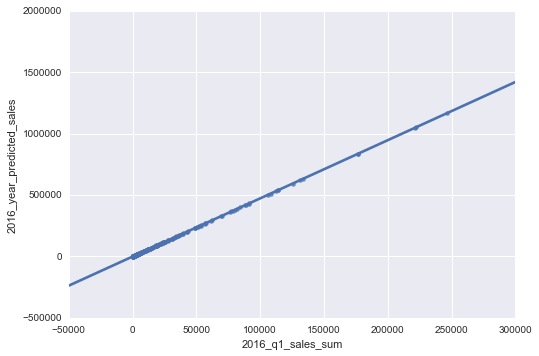

In [64]:
# Top Results
sns.regplot(model_zip2016['2016_q1_sales_sum'],zip_Q1_2016_sales['2016_year_predicted_sales'])

In [65]:
# Top 10 by Zipcode

print "Sum of 2016 Sales:"
print np.sum(dif2['2016_zip_model2']),'\n'

top10 = dif2.sort_values(by='2016_zip_model2').tail(10)

print 'Zip',' -','2016 Sales'
for x,row in top10.iterrows():
      print '%i $%0.2f' % (row['zip_code'],row['2016_zip_model2'])

Sum of 2016 Sales:
28823597.0978 

Zip  - 2016 Sales
52001 $537602.17
50613 $538091.58
51501 $593755.12
52722 $621992.15
50311 $631547.89
50010 $834014.49
52240 $835745.19
52402 $1047696.98
50320 $1051016.54
50314 $1166608.42


In [69]:
(dif2['2016_zip_model2']).head()

0      6990.663626
1     54725.164139
2      9905.471691
3    201889.495284
4    834014.485136
Name: 2016_zip_model2, dtype: float64

In [66]:
# Top 10 by store number

print "Sum of 2016 Sales:"
print np.sum(dif['2016_model2']),'\n'

top10 = dif.sort_values(by='2016_model2').tail(10)

print 'Store',' -','2016 Sales'
for x,row in top10.iterrows():
      print '%i $%0.2f' % (row['store_number'],row['2016_model2'])

Sum of 2016 Sales:
28856911.5223 

Store  - 2016 Sales
2670 $242875.99
3354 $245511.26
3952 $263435.46
3814 $281993.76
3385 $286820.66
3773 $294877.66
3447 $335300.93
2512 $498737.04
4829 $932098.29
2633 $972495.94
